In [14]:
%config IPCompleter.greedy=True

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import json
import glob

In [69]:
def moving_average(x, w):
    x_padded = np.pad(x, (w//2, w-1-w//2), mode='edge')
    return (np.convolve(np.array(x_padded), np.ones(w), 'valid') / w).tolist()

def load_data(path):
    with open(path) as f:
        data = json.load(f)
        return data
    
def load_data_from_dir(path, smooth=False):
    files = glob.glob(path)
    data_preproc = { 'epoch': [], 'reward': [], 'workers': [] }
    for j, file in enumerate(files):
        tmp_data = load_data(file)
        rews = []
        for i in range(len(tmp_data['epoch'])):
            data_preproc['epoch'].append(tmp_data['epoch'][i])
            if smooth:
                rews.append(tmp_data['mean_reward'][i])
            else:
                data_preproc['reward'].append(tmp_data['mean_reward'][i])
        if smooth:
            data_preproc['reward'].extend(moving_average(rews, 10))
        data_preproc['workers'].extend([tmp_data['workers']] * len(tmp_data['epoch']))
    df = pd.DataFrame(data=data_preproc)
    df_wide = df.pivot('epoch', 'workers', 'reward')
    return df_wide

In [70]:
results_wide_torch = load_data_from_dir('../results/torch/Run2/*.json', smooth=True)
results_wide_tf = load_data_from_dir('../results/tf/*.json', smooth=True)
results_wide_ray = load_data_from_dir('../results/ray/*.json') # Ray smooths values by default using window

In [71]:
def plot_results(dataframe, path):
    ax = sns.lineplot(data=dataframe)
    ax.legend(title='Workers')
    ax.set(xlabel='Epochs', ylabel='Average Reward')
    plt.tight_layout()
    plt.show()
    ax.get_figure().savefig(path, dpi=400)

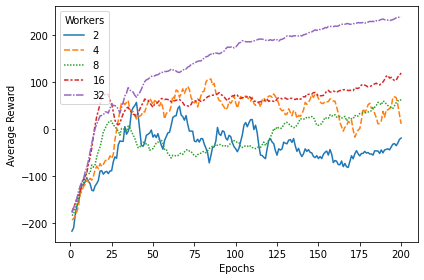

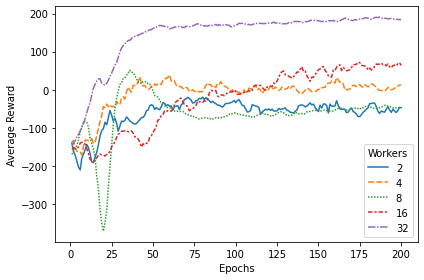

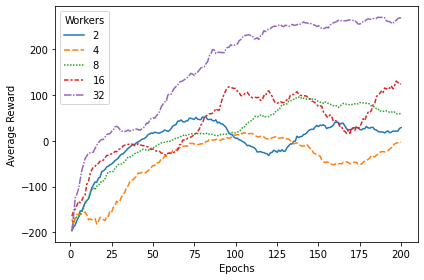

In [72]:
plot_results(results_wide_torch, 'torch_worker_results.png')
plot_results(results_wide_tf, 'tf_worker_results.png')
plot_results(results_wide_ray, 'ray_worker_results.png')